# Bayesian Updating: Posterior Return Probabilities
In this notebook, we explore Bayesian updating related to market regime probabilities. Part 1 covers an expanding approach and Part 2 covers a windowed approach.

### Overview
The future regime of the stock market is a binary outcome, either positive or negative. Because of this fact, future market regimes are analogous to a ***biased*** coin flip with an unknown probability of heads (positive regime). If we have an initial assumption about the behavior of market regimes, we can apply the Bayesian updating process to ***learn*** the probability of a positive regime.

Suppose we are given a price time-series $P_{t}$. The daily return series, $R_{t}$, is<br>
$R_{t}=\frac{P_{t}-P_{t-1}}{P_{t-1}}$

Given the return series $R_{t}$, the market regime, $M_{t}$, is<br>
$
M_{t}=\begin{cases}
\text{1} & \text{if } R_{t} > 0 \\
\text{0} & \text{if } R_{t} \le 0
\end{cases}
$

As we can see, $M_{t} \sim \text{Bernoulli}(p)$, where $p$ is the unknown probability of a positive regime. The objective is to define the Bayesian updating process such that we can infer $p$ as we make new market return observations.<br>
$p \exists [0, 1]$

$p$ itself is a continuous random variable. Because of this, $p$ has a conjugate prior drawn from a $Beta$ distribution. Specifically,<br>
$p \sim \text{Beta}(\alpha, \beta)$

where $\alpha > 0$ and $\beta > 0$

The probability density function is defined as<br>
$p(X=x)=\frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$

Where $B(\alpha,\beta)=\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$

Where $\Gamma(t)=\int_{0}^{\infty} e^{-x}x^{t-1}dx$

The expected value of a $Beta$ random variable is<br>
$E[X]=\frac{\alpha}{\alpha+\beta}$

To ***learn*** the value of $p$ as we make daily return observations, we must start with an initial assumption regarding the parameters of the conjugate prior, also known as hyperparameters. Because $p$ is the parameter of the $Bernoulli$ distribution, and drawn from a $Beta$ distribution, we must set inital values for $\alpha$ and $\beta$.

EXPLAIN THE INTERPRETATION OF ALPHA AND BETA

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from sklearn.metrics import brier_score_loss, log_loss

In [237]:
# Import settings
plt.style.use("ggplot")

TICKER = "SPY"
START  = "2000-01-01"
END    = None

# Period offsets
DAY   = 1
WEEK  = 5  # 5 trading days in month
MONTH = 21 # 21 trading days in month
YEAR = 252 # 252 trading days in year

In [238]:
data = yf.download(TICKER, start=START, end=END, auto_adjust=True)['Close']

data["Rt"] = data[TICKER].pct_change()     # Compute the daily returns
data["Mt"] = (data["Rt"] > 0).astype(int)  # Compute the daily regimes

print(data.head())

[*********************100%***********************]  1 of 1 completed

Ticker            SPY        Rt  Mt
Date                               
2000-01-03  91.617043       NaN   0
2000-01-04  88.034302 -0.039106   0
2000-01-05  88.191780  0.001789   1
2000-01-06  86.774391 -0.016072   0
2000-01-07  91.813911  0.058076   1


## Part 1: Expanded Bayesian Updating
In this section we use the Bayesian updating process on an expanding basis, to estimate the probability (p) for the next positive regime. 

In [239]:
# Set the initial priors
a, b = 1, 1

alphas = []
betas  = []
probs  = []

for i in range(len(data)):
    # Compute posterior probability
    p = a / (a + b)

    # Update the priors (posterior hyperparameters)
    a += 1 if data["Mt"].iloc[i] == 1 else 0
    b += 1 if data["Mt"].iloc[i] == 0 else 0

    # Store
    alphas.append(a)
    betas.append(b)
    probs.append(p)

posteriors = pd.DataFrame(index=data.index)
posteriors["alpha"]  = alphas
posteriors["beta"]   = betas
posteriors["probs"]  = probs

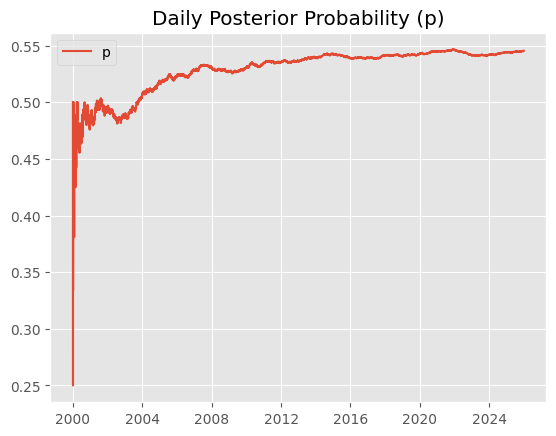

In [240]:
plt.plot(posteriors["probs"], label="p")
plt.title("Daily Posterior Probability (p)")
plt.legend()
plt.show()

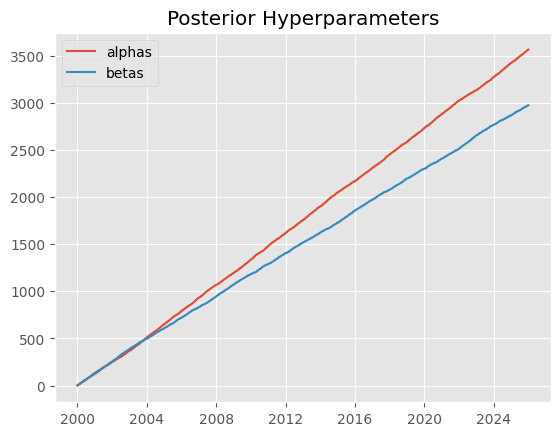

In [241]:
plt.plot(posteriors["alpha"], label="alphas")
plt.plot(posteriors["beta"], label="betas")
plt.title("Posterior Hyperparameters")
plt.legend()
plt.show()

In [242]:
y_true = data["Mt"]
y_prob = posteriors["probs"].shift(1).fillna(0.5)

# Prediction metrics
brier_score    = brier_score_loss(y_true, y_prob)
log_loss_score = log_loss(y_true, y_prob)

print(f"Brier:    {brier_score}")
print(f"Log-Loss: {log_loss_score}")

Brier:    0.24824478129812305
Log-Loss: 0.6896350842641854


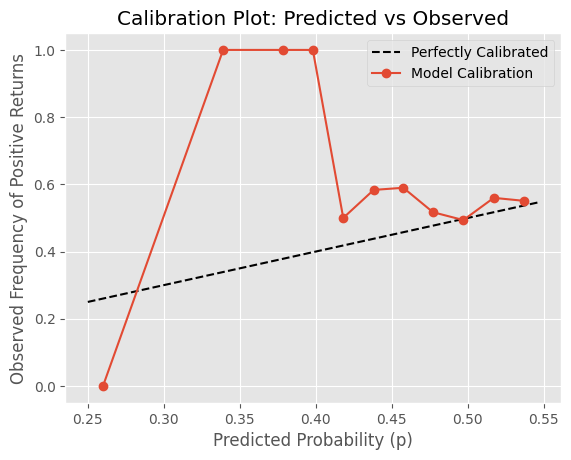

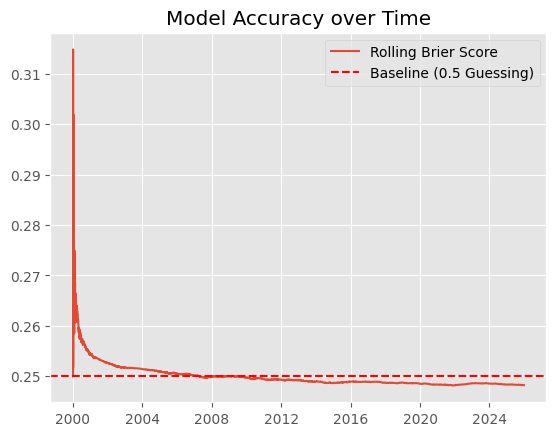

In [243]:
test_df = pd.DataFrame({'prob': y_prob, 'actual': y_true})
test_df['bin'] = pd.cut(test_df['prob'], bins=15)

calibration = test_df.groupby('bin', observed=True)['actual'].mean()

# Calibration plot (predicted vs observed)
plt.plot([y_prob.min(), y_prob.max()], [y_prob.min(), y_prob.max()], 'k--', label='Perfectly Calibrated')
plt.plot(calibration.index.map(lambda x: x.mid), calibration.values, marker='o', label='Model Calibration')
plt.title("Calibration Plot: Predicted vs Observed")
plt.xlabel("Predicted Probability (p)")
plt.ylabel("Observed Frequency of Positive Returns")
plt.legend()
plt.show()

# Model accuracy over time
cum_brier = ((y_prob - y_true)**2).expanding().mean()
plt.plot(cum_brier, label="Rolling Brier Score")
plt.axhline(0.25, color='red', linestyle='--', label="Baseline (0.5 Guessing)")
plt.title("Model Accuracy over Time")
plt.legend()
plt.show()

In [244]:
# Compute horizon returns
data["Rt_week"]  = data[TICKER].pct_change(WEEK)
data["Rt_month"] = data[TICKER].pct_change(MONTH)

# Compute horizon regimes
data["Mt_week"]  = (data["Rt_week"] > 0).astype(int)
data["Mt_month"] = (data["Rt_month"] > 0).astype(int)

In [245]:
# Set the initial priors
a_w, b_w = 1, 1
a_m, b_m = 1, 1

alphas_w, betas_w, probs_w = [], [], []
alphas_m, betas_m, probs_m = [], [], []

for i in range(len(data)):
    # Compute posterior probability
    p_w = a_w / (a_w + b_w)
    p_m = a_m / (a_m + b_m)

    # Update the priors (posterior hyperparameters)
    a_w += 1 if data["Mt_week"].iloc[i] == 1 else 0
    b_w += 1 if data["Mt_week"].iloc[i] == 0 else 0

    a_m += 1 if data["Mt_month"].iloc[i] == 1 else 0
    b_m += 1 if data["Mt_month"].iloc[i] == 0 else 0

    # Store
    alphas_w.append(a_w)
    betas_w.append(b_w)
    probs_w.append(p_w)

    alphas_m.append(a_m)
    betas_m.append(b_m)
    probs_m.append(p_m)

# Update the posterior results
posteriors["alpha_w"], posteriors["alpha_m"]  = alphas_w, alphas_m
posteriors["beta_w"], posteriors["beta_m"]    = betas_w, betas_m
posteriors["probs_w"], posteriors["probs_m"]  = probs_w, probs_m

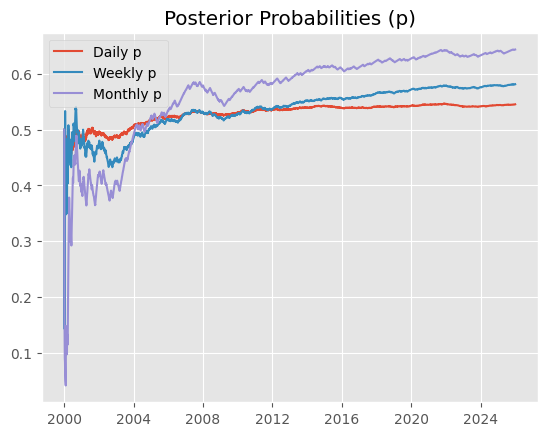

In [246]:
plt.plot(posteriors["probs"], label="Daily p")
plt.plot(posteriors["probs_w"], label="Weekly p")
plt.plot(posteriors["probs_m"], label="Monthly p")
plt.title("Posterior Probabilities (p)")
plt.legend()
plt.show()

In [247]:
y_true_w, y_true_m = data["Mt_week"], data["Mt_month"]
y_prob_w, y_prob_m = posteriors["probs_w"].shift(1).fillna(0.5), posteriors["probs_m"].shift(1).fillna(0.5)

# Prediction metrics
brier_score_w, brier_score_m = brier_score_loss(y_true_w, y_prob_w), brier_score_loss(y_true_m, y_prob_m)
log_loss_score_w, log_loss_score_m = log_loss(y_true_w, y_prob_w), log_loss(y_true_m, y_prob_m)

print(f"Brier (Week):     {brier_score_w}")
print(f"Log-Loss (Week):  {log_loss_score_w}")
print(f"Brier (Month):    {brier_score_m}")
print(f"Log-Loss (Month): {log_loss_score_m}")

Brier (Week):     0.24404424380807793
Log-Loss (Week):  0.6812643851150043
Brier (Month):    0.22997812631549955
Log-Loss (Month): 0.6528782714377687


## Part 2: Windowed Bayesian Updating